<a href="https://colab.research.google.com/github/LiYuan199701/TimeSeries/blob/Bayesian-single-perceptron-TS/non_linear_basis_BNAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load packages

In [110]:
# ===============================
# Bayesian single-perceptron NAR(d)
# with recency-decaying prior means
# ===============================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
# Set inline backend and resolution
%config InlineBackend.figure_format = 'retina'  # For Retina displays
plt.rcParams['figure.dpi'] = 150  # Set dpi to 200 for high resolution

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the simulation models

In [111]:
# ============================================
#   MODEL 1
# ============================================
def simulate_model1(T=2000, sigma_eps=1.0):
    X = np.zeros(T)
    X[0] = np.random.randn()

    for t in range(1, T):
        eps = np.random.randn() * sigma_eps
        if X[t-1] <= 0:
            X[t] = 0.1 * X[t-1] + eps
        else:
            X[t] = 0.8 * X[t-1] + eps
    return X

# ============================================
#   MODEL 2
# ============================================
def simulate_model2(T=2000, sigma_eps=1.0):
    X = np.zeros(T)
    X[:3] = np.random.randn(3)

    for t in range(3, T):
        eps = np.random.randn() * sigma_eps
        if X[t-1] <= 0:
            X[t] = 0.5*X[t-1] + 0.2*X[t-2] + 0.1*X[t-3] + eps
        else:
            X[t] = 0.8*X[t-1] + eps
    return X

# ============================================
#   MODEL 3
# ============================================
def simulate_model3(T=2000, sigma_eps=1.0):
    X = np.zeros(T)
    X[0] = np.random.randn()

    for t in range(1, T):
        eps = np.random.randn()
        if X[t-1] <= 0:
            X[t] = 0.1 * X[t-1] + 0.5*np.exp(-X[t-1]**2) * eps
        else:
            X[t] = 0.8 * X[t-1] + 0.5*np.exp(-X[t-1]**2) * eps
    return X

# ============================================
#   MODEL 4
# ============================================
def simulate_model4(T=2000, sigma_eps=1.0):
    X = np.zeros(T)
    X[0] = np.random.randn()

    for t in range(1, T):
        eps = np.random.randn() * sigma_eps
        X[t] = 0.2 + np.log(0.5 + np.abs(X[t-1])) + eps
    return X

# ============================================
#   MODEL 5
# ============================================
def simulate_model5(T=2000, sigma_eps=1.0):
    X = np.zeros(T)
    X[0] = np.random.randn() + 1.0

    for t in range(1, T):
        eps = np.random.randn() * sigma_eps
        X[t] = 2 * np.log(X[t-1]**2 + 1e-6) + eps
    return X

# ============================================
#   MODEL 6
# ============================================
def simulate_model6(T=2000, sigma_eps=1.0):
    X = np.zeros(T)
    X[0] = np.random.randn()

    for t in range(1, T):
        eps = np.random.randn() * sigma_eps
        X[t] = np.log(10 + 5 * np.exp(0.9 * X[t-1])) + eps
    return X

# ============================================
#   MODEL 7
# ============================================
def simulate_model7(T=2000, sigma_eps=1.0):
    X = np.zeros(T)
    X[:3] = np.random.randn(3)

    for t in range(3, T):
        eps = np.random.randn() * sigma_eps
        term = (4*np.exp(0.9*X[t-2]) +
                5*np.exp(0.9*X[t-1]) +
                6*np.exp(0.9*X[t-3]))
        X[t] = np.log(term) + eps
    return X

# =====================================================
# Unified wrapper
# =====================================================
def simulate(model_id, T=2000, sigma_eps=1.0):
    if model_id == 1: return simulate_model1(T, sigma_eps)
    if model_id == 2: return simulate_model2(T, sigma_eps)
    if model_id == 3: return simulate_model3(T, sigma_eps)
    if model_id == 4: return simulate_model4(T, sigma_eps)
    if model_id == 5: return simulate_model5(T, sigma_eps)
    if model_id == 6: return simulate_model6(T, sigma_eps)
    if model_id == 7: return simulate_model7(T, sigma_eps)
    raise ValueError("Model ID must be 1–7")

# Generate simulation data

x_min: 0.4001572083672233
x_max: 34.726934321506874
x_mean: 27.97821791831005
x_std: 3.0897303973314036


Text(0.5, 1.0, 'Model 7 Time Series')

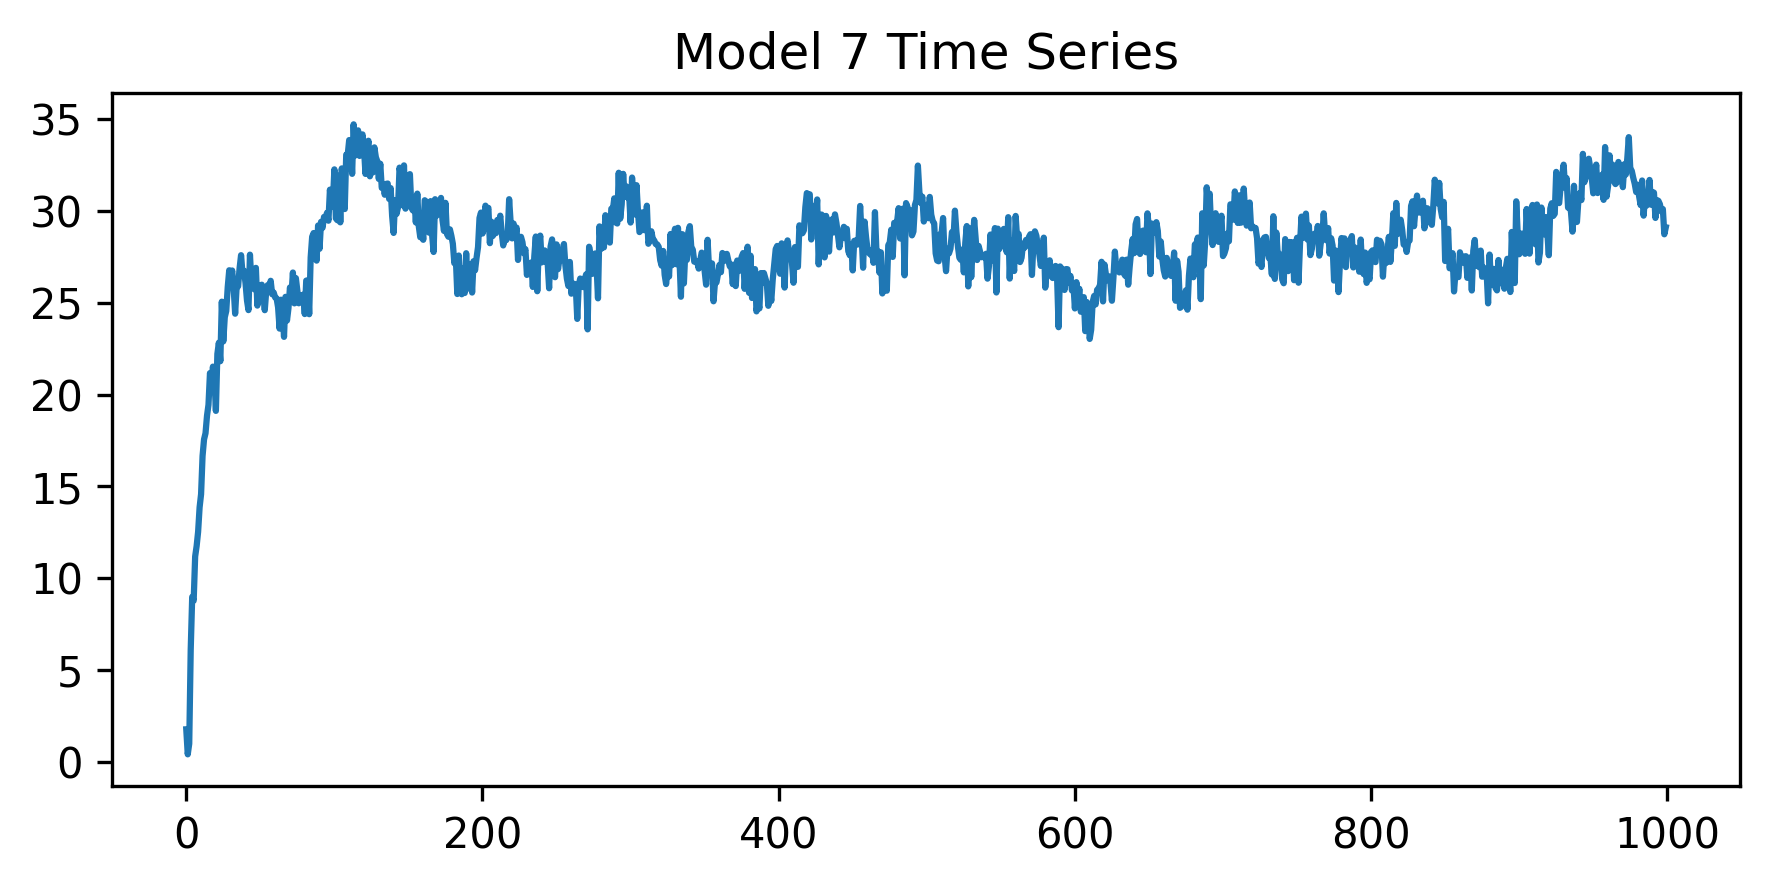

In [112]:
# Set a random seed
np.random.seed(0)
# Set the number of samples
T = 1000
id = 7
x = simulate(model_id=id, T = T)
# create the summary statistics of x time series including min and max
x_min = np.min(x)
x_max = np.max(x)
x_mean = np.mean(x)
x_std = np.std(x)
# print the summary statistics
print("x_min:", x_min)
print("x_max:", x_max)
print("x_mean:", x_mean)
print("x_std:", x_std)

# plot this time series
plt.figure(figsize=(7,3))
plt.plot(x)
# change title name by model id
plt.title(f"Model {id} Time Series")

# Define functions to form lag and build nonlinear basis

In [113]:
import numpy as np
import torch

# ----------------------------------------------------------
# 1. Scaling function
# ----------------------------------------------------------
def scale_to_unit_interval(X, do_scale=True):
    """
    Scale time series X to [-1, 1] ONLY IF:
        (1) do_scale=True, AND
        (2) X is not already in [-1, 1].

    Returns:
        X_scaled, scale_factor c
    """
    X = np.asarray(X).reshape(-1)

    # If user disables scaling
    if not do_scale:
        return X, 1.0

    X_min = np.min(X)
    X_max = np.max(X)

    # If the entire series is already within [-1, 1], don't scale
    if X_min >= -1.0 and X_max <= 1.0:
        return X, 1.0

    # Otherwise compute scale c
    c = max(abs(X_min), abs(X_max))
    if c < 1e-12:
        c = 1.0   # avoid divide-by-zero for constant series

    return X / c, c



# ----------------------------------------------------------
# 2. Build lag matrix
# ----------------------------------------------------------
def build_lag_matrix(x, d):
    """
    x: 1-D array (N,)
    d: number of lags

    Returns:
        X_lag: shape (N-d, d)
        y:     shape (N-d,)
    """
    x = np.asarray(x).reshape(-1)
    N = len(x)

    X_lag = np.zeros((N - d, d))
    for k in range(1, d + 1):
        X_lag[:, k - 1] = x[d - k : N - k]

    y = x[d:]
    return X_lag, y


# ----------------------------------------------------------
# 3. Build basis for a single column
# ----------------------------------------------------------
def build_basis(x, poly_degree=3, fourier_freqs=[1,2,3], use_abs=True, use_log=False):
    x = np.asarray(x).reshape(-1)
    N = len(x)
    features = []

    # identity
    features.append(x.reshape(N,1))

    # polynomial
    for p in range(2, poly_degree+1):
        features.append((x**p).reshape(N,1))

    # absolute value
    if use_abs:
        features.append(np.abs(x).reshape(N,1))

    # log term
    if use_log:
        features.append(np.log(1e-6 + np.abs(x)).reshape(N,1))

    # Fourier
    if fourier_freqs is not None:
        for w in fourier_freqs:
            features.append(np.sin(w*np.pi*x).reshape(N,1))
            features.append(np.cos(w*np.pi*x).reshape(N,1))

    return np.concatenate(features, axis=1)


# ----------------------------------------------------------
# 4. Build full basis (Option D-1)
# ----------------------------------------------------------
def build_full_basis(X_lag, poly_degree=3, fourier_freqs=[1,2,3], use_abs=True, use_log=False):
    """
    Apply basis to each lag column separately and concatenate.
    """
    N, d = X_lag.shape
    basis_list = []

    for k in range(d):   # loop over lag variables
        col = X_lag[:, k]
        Bk = build_basis(col,
                         poly_degree=poly_degree,
                         fourier_freqs=fourier_freqs,
                         use_abs=use_abs,
                         use_log=use_log)
        basis_list.append(Bk)

    return np.concatenate(basis_list, axis=1)

# Scale Data

Text(0.5, 1.0, 'Scaled Model 7 Time Series')

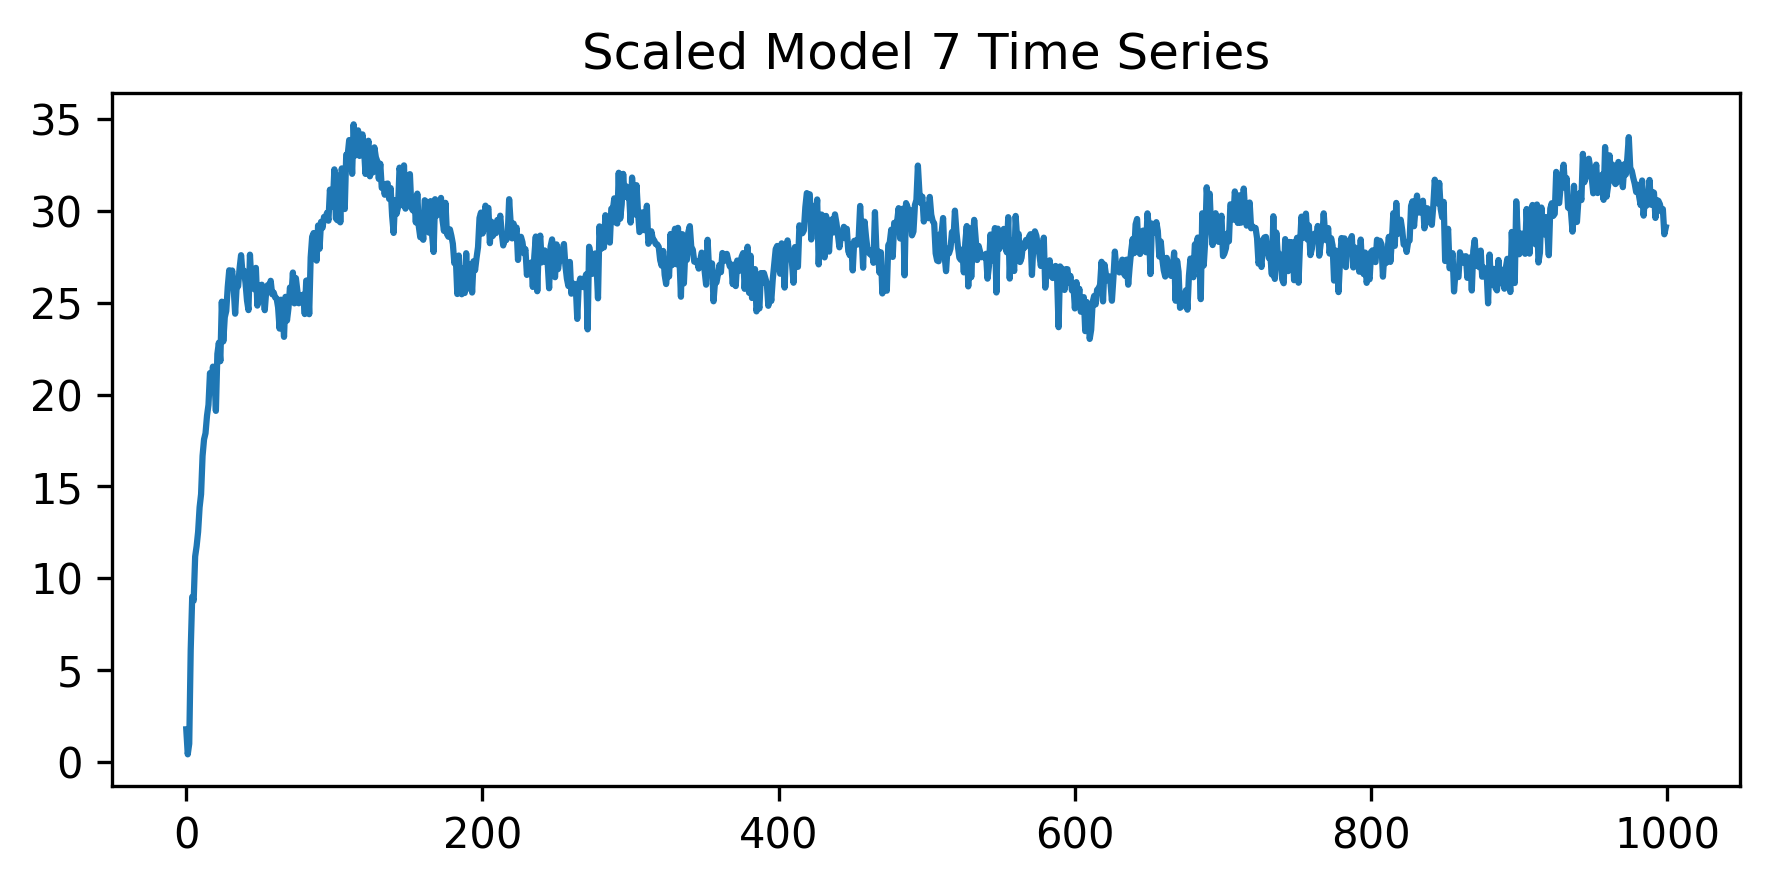

In [114]:
x_scaled, c = scale_to_unit_interval(x, False)
# plot this time series
plt.figure(figsize=(7,3))
plt.plot(x_scaled)
# change title name by model id
plt.title(f"Scaled Model {id} Time Series")

# Create lag and Build Basis

In [115]:
d = 2   # number of lags
X_lag, y = build_lag_matrix(x_scaled, d)
print("X_lag shape:", X_lag.shape)
print("y shape:", y.shape)

# -----------------
# 3. basis expansion
# -----------------
X_basis = build_full_basis(
    X_lag,
    poly_degree=3,
    fourier_freqs=[1,2,3],
    use_abs=True,
    use_log=False
)

print("X_basis shape:", X_basis.shape)
# Build a dataframe from X_basis to display
df = pd.DataFrame(X_basis, columns=[f"x{i}" for i in range(X_basis.shape[1])])
# add y to a new column of df
df["y"] = y
df

X_lag shape: (998, 2)
y shape: (998,)
X_basis shape: (998, 20)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,y
0,0.400157,0.160126,0.064075,0.400157,0.951209,0.308547,0.586986,-0.809597,-0.588983,-0.808145,...,3.111881,5.489520,1.764052,-0.675212,0.737624,-0.996105,0.088179,-0.794290,-0.607539,0.978738
1,0.978738,0.957928,0.937561,0.978738,0.066747,-0.997770,-0.133196,0.991090,0.199051,-0.979989,...,0.160126,0.064075,0.400157,0.951209,0.308547,0.586986,-0.809597,-0.588983,-0.808145,6.094278
2,6.094278,37.140225,226.342856,6.094278,0.291872,0.956457,0.558326,0.829622,0.776158,0.630538,...,0.957928,0.937561,0.978738,0.066747,-0.997770,-0.133196,0.991090,0.199051,-0.979989,8.976880
3,8.976880,80.584367,723.396158,8.976880,0.072571,-0.997363,-0.144759,0.989467,0.216184,-0.976353,...,37.140225,226.342856,6.094278,0.291872,0.956457,0.558326,0.829622,0.776158,0.630538,8.770237
4,8.770237,76.917054,674.580780,8.770237,0.660754,-0.750603,-0.991927,0.126809,0.828333,0.560236,...,80.584367,723.396158,8.976880,0.072571,-0.997363,-0.144759,0.989467,0.216184,-0.976353,11.180999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,30.557088,933.735614,28532.241124,30.557088,0.983960,-0.178387,-0.351051,-0.936356,-0.858715,0.512454,...,936.378025,28653.443365,30.600295,0.950770,-0.309897,-0.589281,-0.807928,-0.585537,0.810645,30.378612
994,30.378612,922.860069,28035.207991,30.378612,0.928162,0.372175,0.690878,-0.722971,-0.413907,-0.910319,...,933.735614,28532.241124,30.557088,0.983960,-0.178387,-0.351051,-0.936356,-0.858715,0.512454,29.976850
995,29.976850,898.611523,26937.542647,29.976850,-0.072664,0.997356,-0.144945,0.989440,-0.216459,0.976292,...,922.860069,28035.207991,30.378612,0.928162,0.372175,0.690878,-0.722971,-0.413907,-0.910319,30.111045
996,30.111045,906.675005,27300.931467,30.111045,0.341824,0.939764,0.642467,0.766313,0.865712,0.500543,...,898.611523,26937.542647,29.976850,-0.072664,0.997356,-0.144945,0.989440,-0.216459,0.976292,28.736019


# Create the Train/Dev/Test and Tensor

In [116]:
N = len(y)
# Train/val/test split by time
n_train = int(0.7*N)
n_val   = int(0.15*N)
idx_tr  = slice(0, n_train)
idx_va  = slice(n_train, n_train+n_val)
idx_te  = slice(n_train+n_val, N)

Xtr, ytr = X_basis[idx_tr], y[idx_tr]
Xva, yva = X_basis[idx_va], y[idx_va]
Xte, yte = X_basis[idx_te], y[idx_te]

Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr, dtype=torch.float32, device=device).unsqueeze(1)
Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)
yva_t = torch.tensor(yva, dtype=torch.float32, device=device).unsqueeze(1)
Xte_t = torch.tensor(Xte, dtype=torch.float32, device=device)
yte_t = torch.tensor(yte, dtype=torch.float32, device=device).unsqueeze(1)

# print shape and Xtr_t
print("Xtr_t shape:", Xtr_t.shape)
print(Xtr_t[:2])
print("ytr_t shape:", ytr_t.shape)
print(ytr_t[:2])
print("Xtr_t dtype:", Xtr_t.dtype)
print("Xtr_t device:", Xtr_t.device)

# form Xtr, ytr into a dataframe
df = pd.DataFrame(Xte_t.cpu().numpy(), columns=[f"x{i}" for i in range(Xte_t.shape[1])])
df["y"] = yte
df.head()

Xtr_t shape: torch.Size([698, 20])
tensor([[ 0.4002,  0.1601,  0.0641,  0.4002,  0.9512,  0.3085,  0.5870, -0.8096,
         -0.5890, -0.8081,  1.7641,  3.1119,  5.4895,  1.7641, -0.6752,  0.7376,
         -0.9961,  0.0882, -0.7943, -0.6075],
        [ 0.9787,  0.9579,  0.9376,  0.9787,  0.0667, -0.9978, -0.1332,  0.9911,
          0.1991, -0.9800,  0.4002,  0.1601,  0.0641,  0.4002,  0.9512,  0.3085,
          0.5870, -0.8096, -0.5890, -0.8081]])
ytr_t shape: torch.Size([698, 1])
tensor([[0.9787],
        [6.0943]])
Xtr_t dtype: torch.float32
Xtr_t device: cpu


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,y
0,29.662996,879.893311,26100.271484,29.662996,-0.871734,0.489979,-0.854263,-0.519842,0.034594,-0.999401,...,907.220032,27325.552734,30.120094,0.368399,0.929668,0.684977,0.728565,0.905203,0.424979,30.502389
1,30.502388,930.395691,28379.291016,30.502388,0.999972,-0.007504,-0.015008,-0.999887,-0.999747,0.022511,...,879.893311,26100.271484,29.662996,-0.871734,0.489979,-0.854263,-0.519842,0.034594,-0.999401,27.279221
2,27.279221,744.155884,20299.992188,27.279221,-0.768950,-0.639309,0.983193,-0.182568,-0.488178,0.872744,...,930.395691,28379.291016,30.502388,0.999972,-0.007504,-0.015008,-0.999887,-0.999747,0.022511,28.257402
3,28.257402,798.480774,22562.992188,28.257402,0.723357,0.690475,0.998919,-0.046489,0.656100,-0.754674,...,744.155884,20299.992188,27.279221,-0.768950,-0.639309,0.983193,-0.182568,-0.488178,0.872744,29.033222
4,29.033222,842.927979,24472.916016,29.033222,-0.104181,-0.994558,0.207228,0.978293,-0.308020,-0.951380,...,798.480774,22562.992188,28.257402,0.723357,0.690475,0.998919,-0.046489,0.656100,-0.754674,26.883984


# Define BNAR-FullCov with Independent Gaussian Prior Class

In [117]:
# ============================================
# Module 2: model_block.py
# BNAR-FullCov with Independent Gaussian Prior
# ============================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class BNAR_FullCov(nn.Module):

    def __init__(self, d, activation="tanh", prior_std=1.0, sigma_floor = 0.9):
        """
        d: number of basis-expanded input features
        activation: "tanh", "identity", "relu", "elu", "softplus"
        prior_std: std of independent Gaussian prior p(w) = N(0, prior_std^2 I)
        """
        super().__init__()
        self.d = d
        self.prior_std = prior_std
        self.activation_name = activation
        self.activation = self.get_activation(activation)
        self.sigma_floor = sigma_floor

        # variational mean
        self.m_w = nn.Parameter(torch.randn(d) * 0.1)

        # diagonal log std for Lq diagonal
        self.log_diag_Lq = nn.Parameter(torch.full((d,), math.log(0.1)))

        # strictly lower triangular unconstrained parameters
        tril_idx = torch.tril_indices(d, d, offset=-1)
        self.Lq_offdiag = nn.Parameter(torch.zeros(tril_idx.shape[1]))

        # bias term
        self.b = nn.Parameter(torch.tensor(0.0))

        # observation noise (Gaussian)
        self.log_sigma_eps = nn.Parameter(torch.tensor(math.log(0.1)))

    # ------------------------------------------------------------
    def get_activation(self, name):
        if name == "tanh":
            return torch.tanh
        elif name == "identity":
            return lambda x: x
        elif name == "relu":
            return F.relu
        elif name == "elu":
            return F.elu
        elif name == "softplus":
            return F.softplus
        else:
            raise ValueError(f"Unknown activation: {name}")

    # ------------------------------------------------------------
    def get_Lq(self, device):
        """Build lower triangular matrix L_q."""
        L_q = torch.zeros(self.d, self.d, device=device)
        tril_idx = torch.tril_indices(self.d, self.d, offset=-1)

        # fill strictly lower elements
        L_q[tril_idx[0], tril_idx[1]] = self.Lq_offdiag

        # add positive diagonal
        L_q = L_q + torch.diag(torch.exp(self.log_diag_Lq))
        return L_q

    # ------------------------------------------------------------
    def kl_gaussian_full(self, mu_q, L_q):
        """
        KL( q(w) || p(w) )
        Prior: p(w) = N(0, prior_std^2 I)
        q(w) = N(mu_q, L_q L_q^T)
        """
        d = mu_q.shape[0]
        Sigma_q = L_q @ L_q.T

        # prior precision: 1 / prior_std^2
        prior_var = self.prior_std ** 2
        Sigma_p_inv = torch.eye(d, device=mu_q.device) / prior_var

        trace_term = torch.trace(Sigma_p_inv @ Sigma_q)
        quad_term = (mu_q @ Sigma_p_inv @ mu_q)

        # log determinants
        log_det_q = 2 * torch.sum(torch.log(torch.diag(L_q)))
        log_det_p = d * math.log(prior_var)

        kl = 0.5 * (trace_term + quad_term - d + log_det_p - log_det_q)
        return kl

    # ------------------------------------------------------------
    def forward(self, X, sample=True, kl_weight=1.0):
        """
        X: (n_samples, d) tensor
        """
        device = X.device
        L_q = self.get_Lq(device)

        if sample and self.training:
            eps = torch.randn(self.d, device=device)
            w = self.m_w + L_q @ eps
        else:
            w = self.m_w

        lin = (X @ w).unsqueeze(1) + self.b
        yhat = self.activation(lin)

        sigma_eps = F.softplus(self.log_sigma_eps) + self.sigma_floor
        kl = self.kl_gaussian_full(self.m_w, L_q)

        return yhat, sigma_eps, kl_weight * kl

    # ------------------------------------------------------------
    def negative_elbo(self, X, y, kl_weight=1.0):
        yhat, sigma_eps, kl_term = self.forward(X, sample=True, kl_weight=kl_weight)

        n = X.shape[0]
        log_likelihood = (
            -0.5 * n * torch.log(2 * torch.tensor(math.pi) * sigma_eps**2)
            - 0.5 * torch.sum((y - yhat)**2) / (sigma_eps**2)
        )

        return -log_likelihood + kl_term, yhat

# Define functions to train

In [118]:
def train_bnar(
    model,
    Xtr_t, ytr_t,
    Xva_t=None, yva_t=None,
    lr=1e-3,
    max_epochs=3000,
    kl_weight=1.0,
    print_every=200,
    patience=300
):
    """
    Train BNAR model using negative ELBO loss with optional validation early stopping.

    model: BNAR_FullCov model
    Xtr_t, ytr_t: training tensors
    Xva_t, yva_t: validation tensors (optional)
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = np.inf
    best_state = None
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(1, max_epochs + 1):
        model.train()

        neg_elbo, _ = model.negative_elbo(Xtr_t, ytr_t, kl_weight=kl_weight)

        optimizer.zero_grad()
        neg_elbo.backward()
        optimizer.step()

        train_losses.append(neg_elbo.item())

        # ----------------------
        # Validation (optional)
        # ----------------------
        if Xva_t is not None:
            model.eval()
            with torch.no_grad():
                val_neg_elbo, _ = model.negative_elbo(Xva_t, yva_t, kl_weight=kl_weight)

            val_losses.append(val_neg_elbo.item())

            # Early stopping check
            if val_neg_elbo.item() < best_val_loss:
                best_val_loss = val_neg_elbo.item()
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch} — no improvement for {patience} epochs.")
                break
        else:
            # If no validation, still track best model
            if neg_elbo.item() < best_val_loss:
                best_val_loss = neg_elbo.item()
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        # ----------------------
        # Print progress
        # ----------------------
        if epoch % print_every == 0 or epoch == 1:
            if Xva_t is not None:
                print(f"Epoch {epoch}/{max_epochs} | "
                      f"Train Loss = {neg_elbo.item():.4f} | "
                      f"Val Loss = {val_neg_elbo.item():.4f}")
            else:
                print(f"Epoch {epoch}/{max_epochs} | Train Loss = {neg_elbo.item():.4f}")

    # ----------------------
    # Load best model
    # ----------------------
    if best_state is not None:
        model.load_state_dict(best_state)
        print("\n✔ Loaded best model (lowest validation loss).")
    else:
        print("\n⚠ No validation set used; final model used as best.")

    return train_losses, val_losses

# Initialize the model

In [119]:
input_dim = Xtr_t.shape[1]

model = BNAR_FullCov(
    d=input_dim,
    activation = "identity",     # or "identity" / "elu" / "relu"
    sigma_floor = 0.9
)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

BNAR_FullCov()
Total parameters: 232


# Start Training

Epoch 1/3000 | Train Loss = 281930080.0000 | Val Loss = 447392928.0000
Epoch 200/3000 | Train Loss = 1488900352.0000 | Val Loss = 12134425.0000
Epoch 400/3000 | Train Loss = 1549221248.0000 | Val Loss = 3077972.7500
Epoch 600/3000 | Train Loss = 408089056.0000 | Val Loss = 2964024.7500
Epoch 800/3000 | Train Loss = 572971072.0000 | Val Loss = 4582994.5000
Epoch 1000/3000 | Train Loss = 37066424.0000 | Val Loss = 8009588.0000
Epoch 1200/3000 | Train Loss = 266735008.0000 | Val Loss = 1696787.3750
Epoch 1400/3000 | Train Loss = 27859782.0000 | Val Loss = 1601841.2500
Epoch 1600/3000 | Train Loss = 34966500.0000 | Val Loss = 2947256.5000
Epoch 1800/3000 | Train Loss = 176823200.0000 | Val Loss = 2647756.5000
Epoch 2000/3000 | Train Loss = 204617136.0000 | Val Loss = 1265800.6250
Epoch 2200/3000 | Train Loss = 18992484.0000 | Val Loss = 1585597.2500
Epoch 2400/3000 | Train Loss = 16994122.0000 | Val Loss = 783144.5625
Epoch 2600/3000 | Train Loss = 153391376.0000 | Val Loss = 312748.8125
E

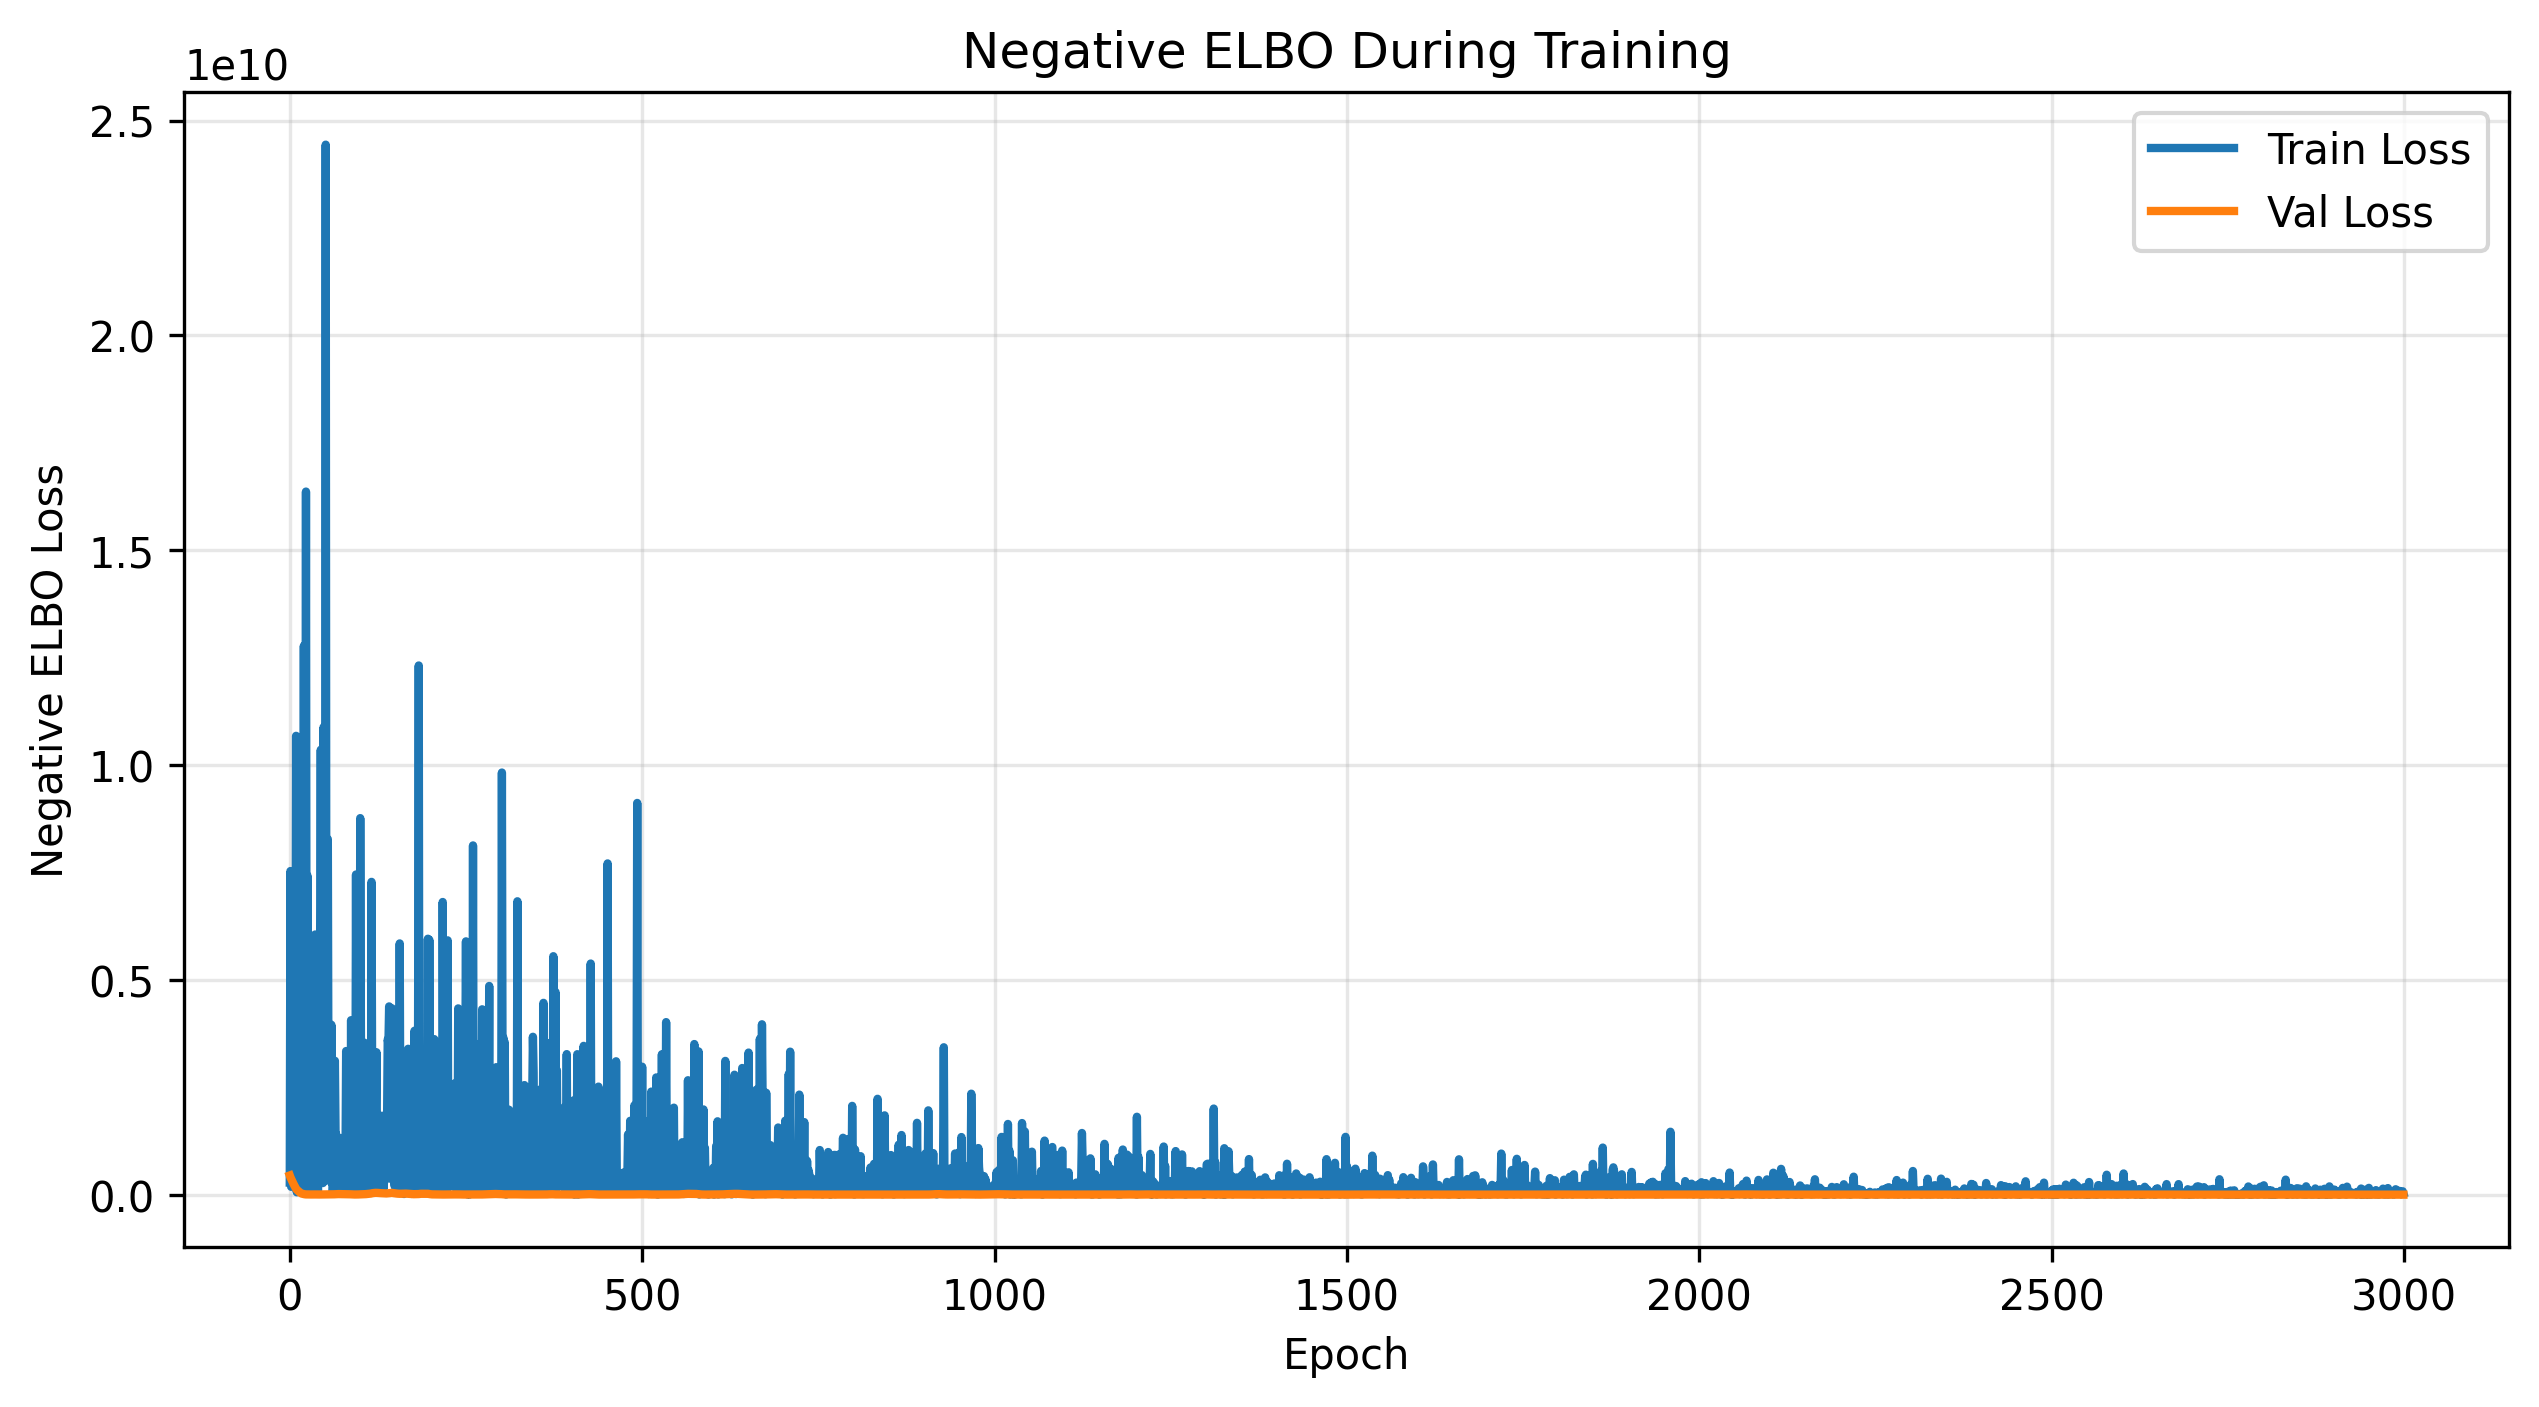

In [120]:
# ================================================
#  STEP 5 — Train the Model
# ================================================
train_losses, val_losses = train_bnar(
    model,
    Xtr_t, ytr_t,
    Xva_t, yva_t,
    lr=3e-3,
    max_epochs=3000,
    kl_weight=1.0,
    patience=500,
    print_every=200
)


# ================================================
#  STEP 6 — Plot Loss Curves
# ================================================
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss", linewidth=2)
if len(val_losses) > 0:
    plt.plot(val_losses, label="Val Loss", linewidth=2)

plt.title("Negative ELBO During Training")
plt.xlabel("Epoch")
plt.ylabel("Negative ELBO Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Evaluate

Generating MC predictions...


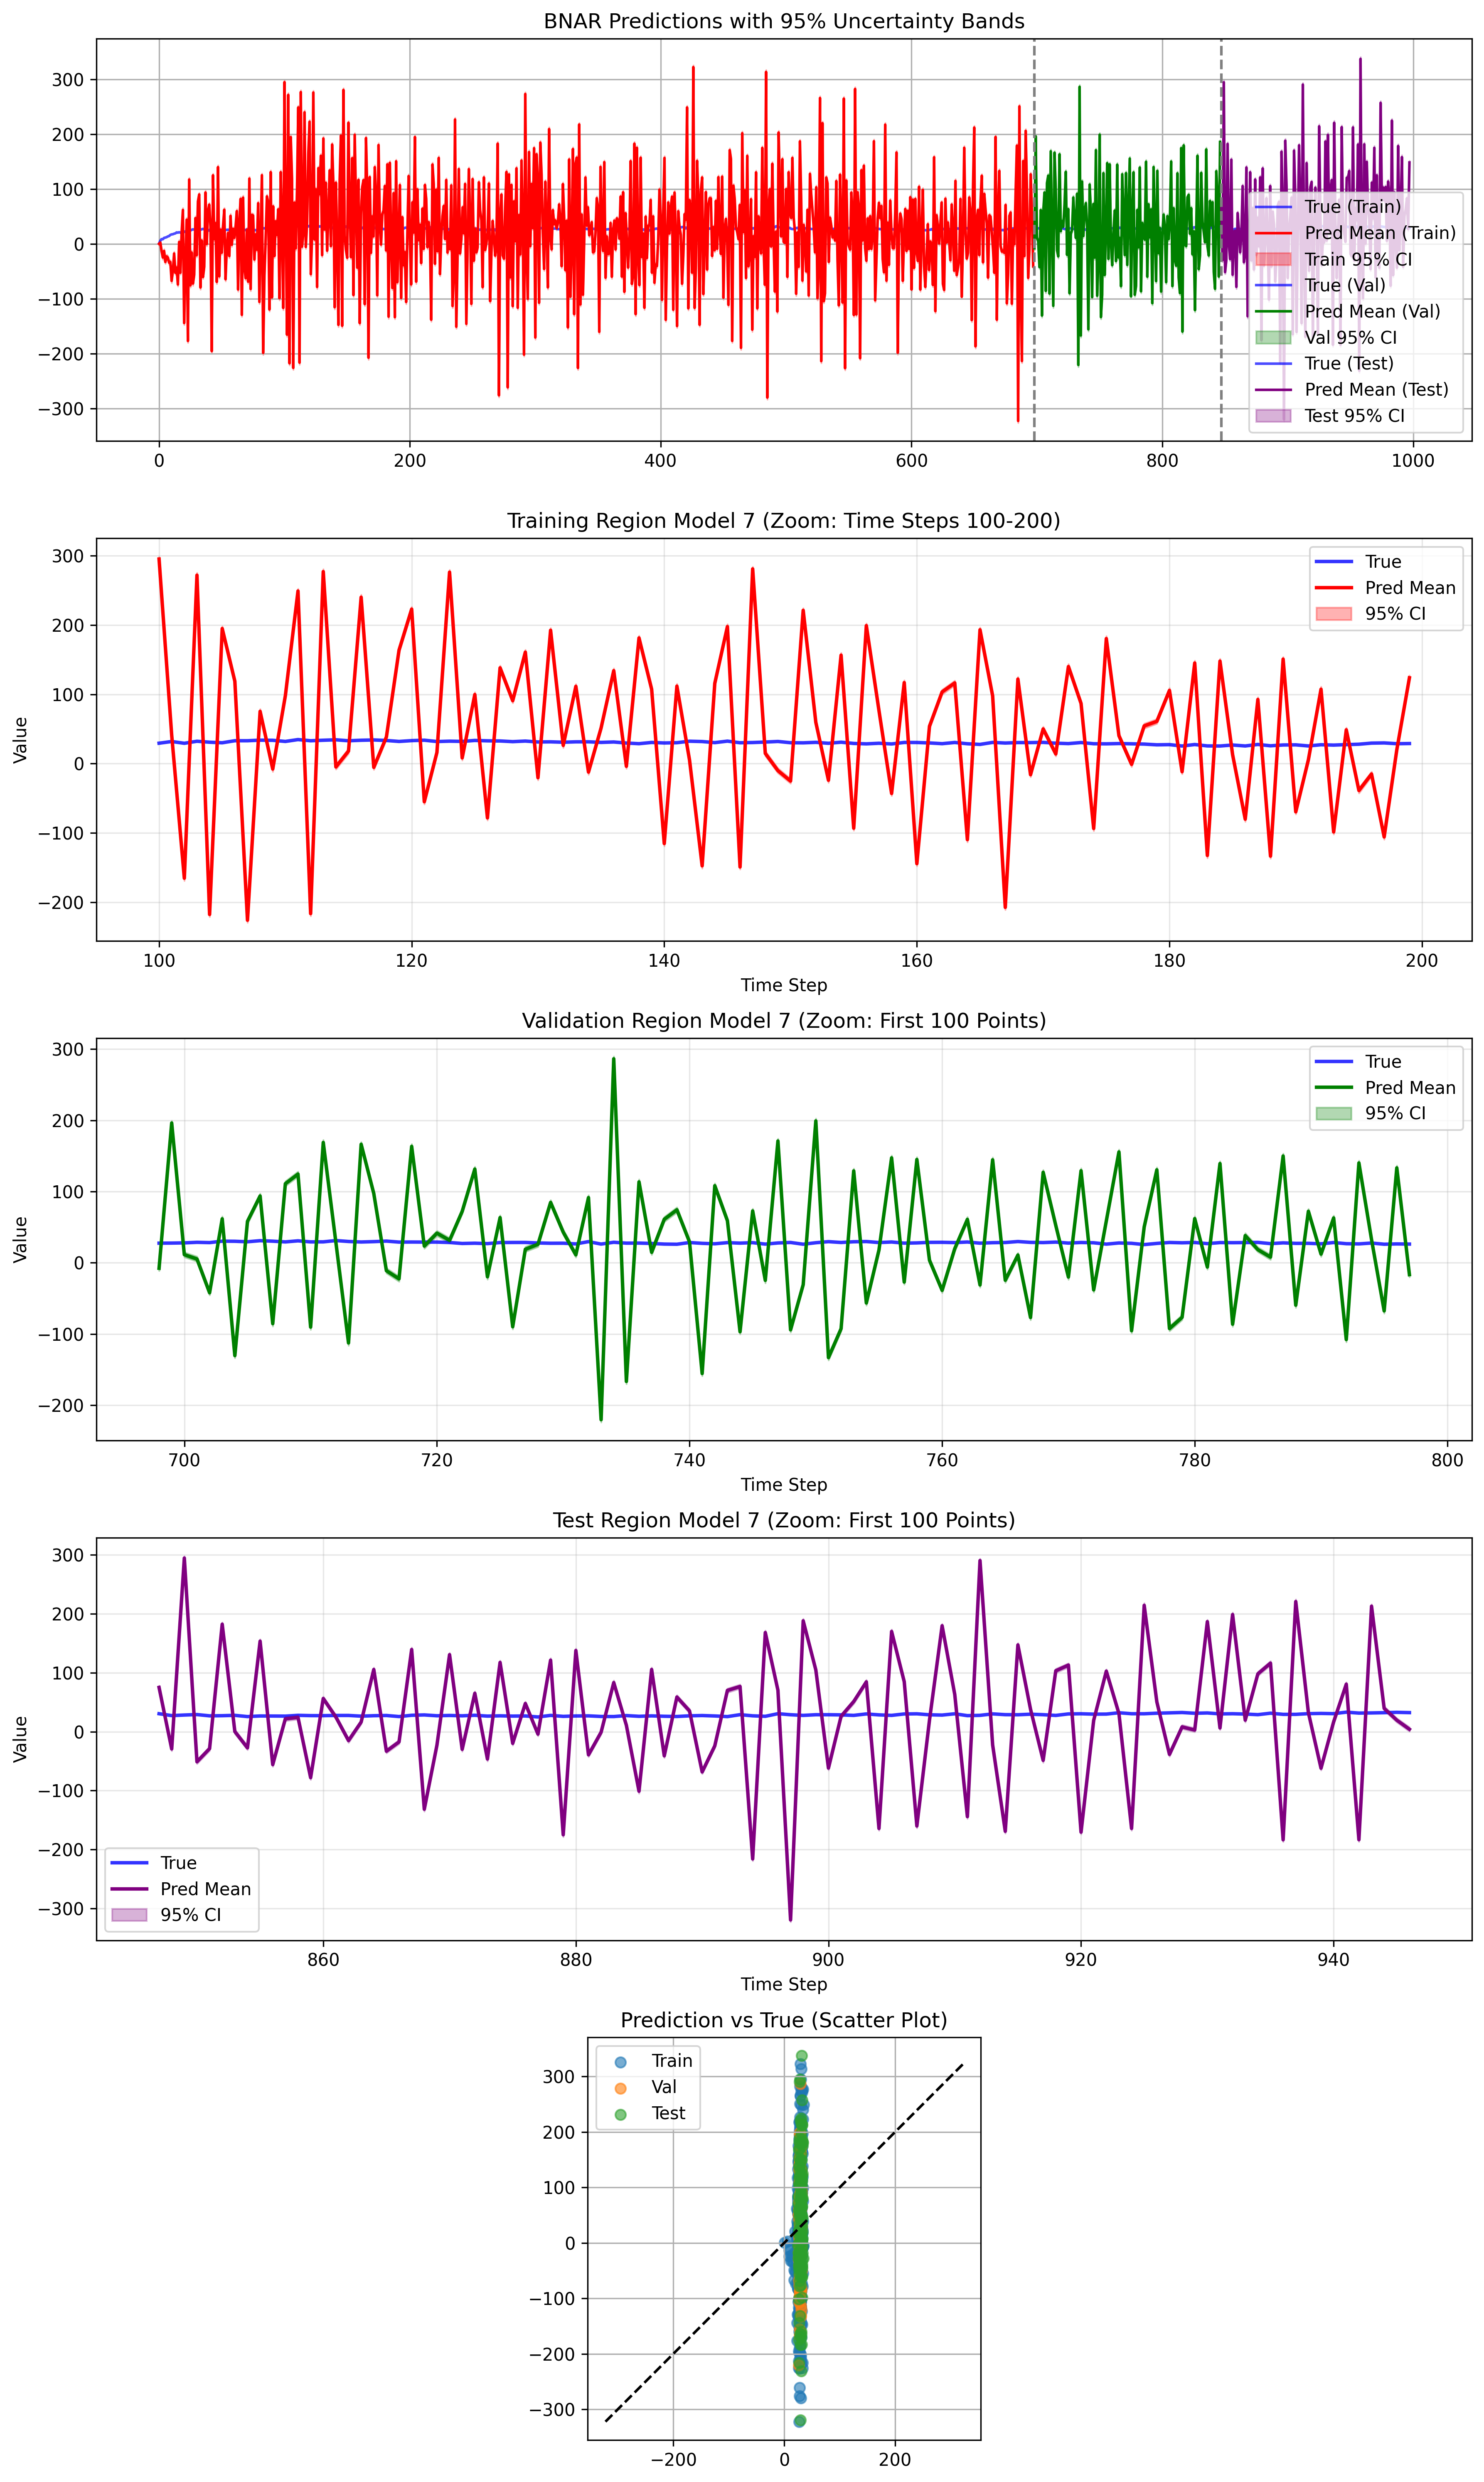

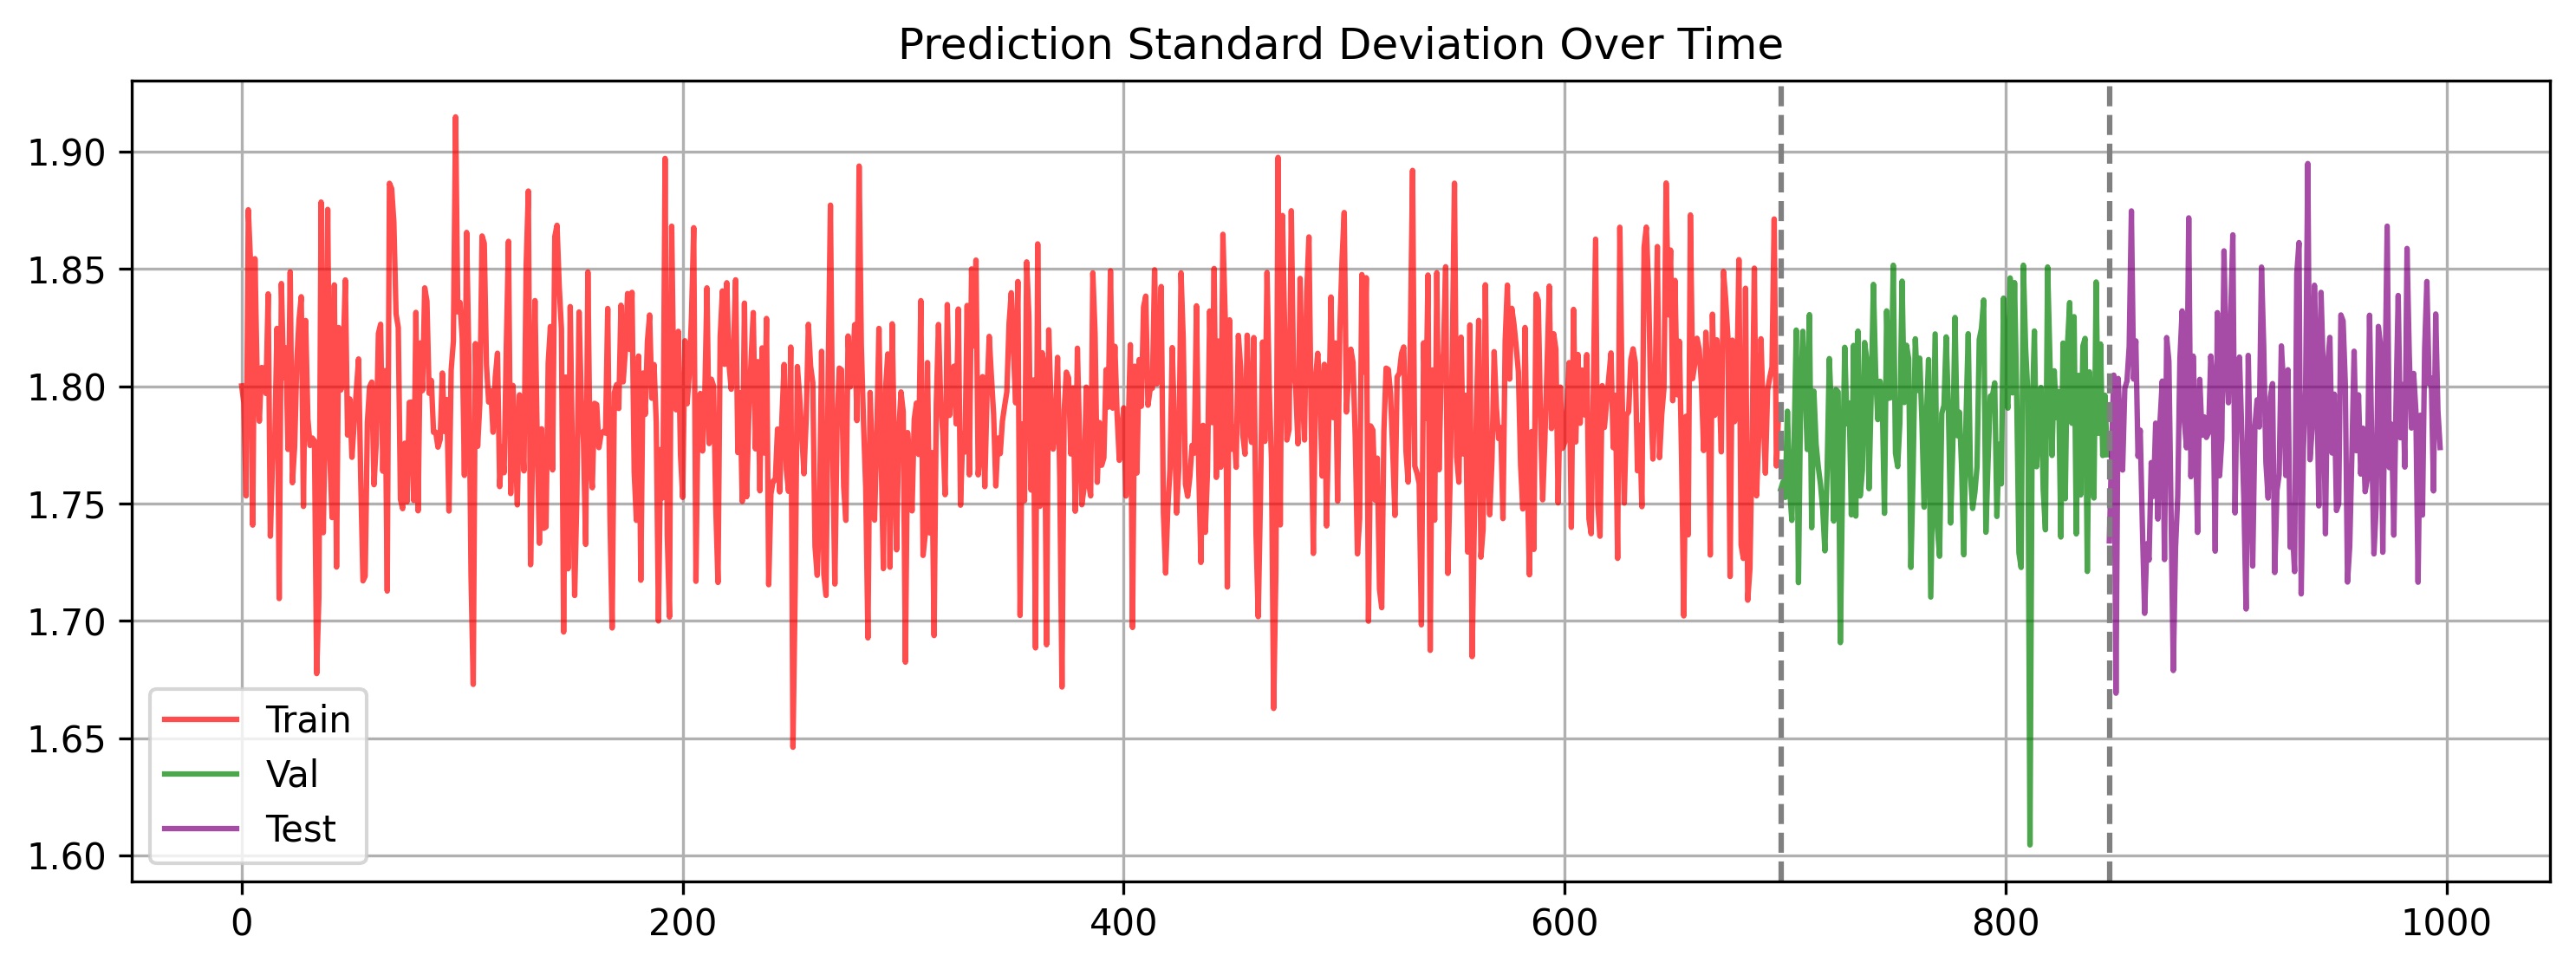

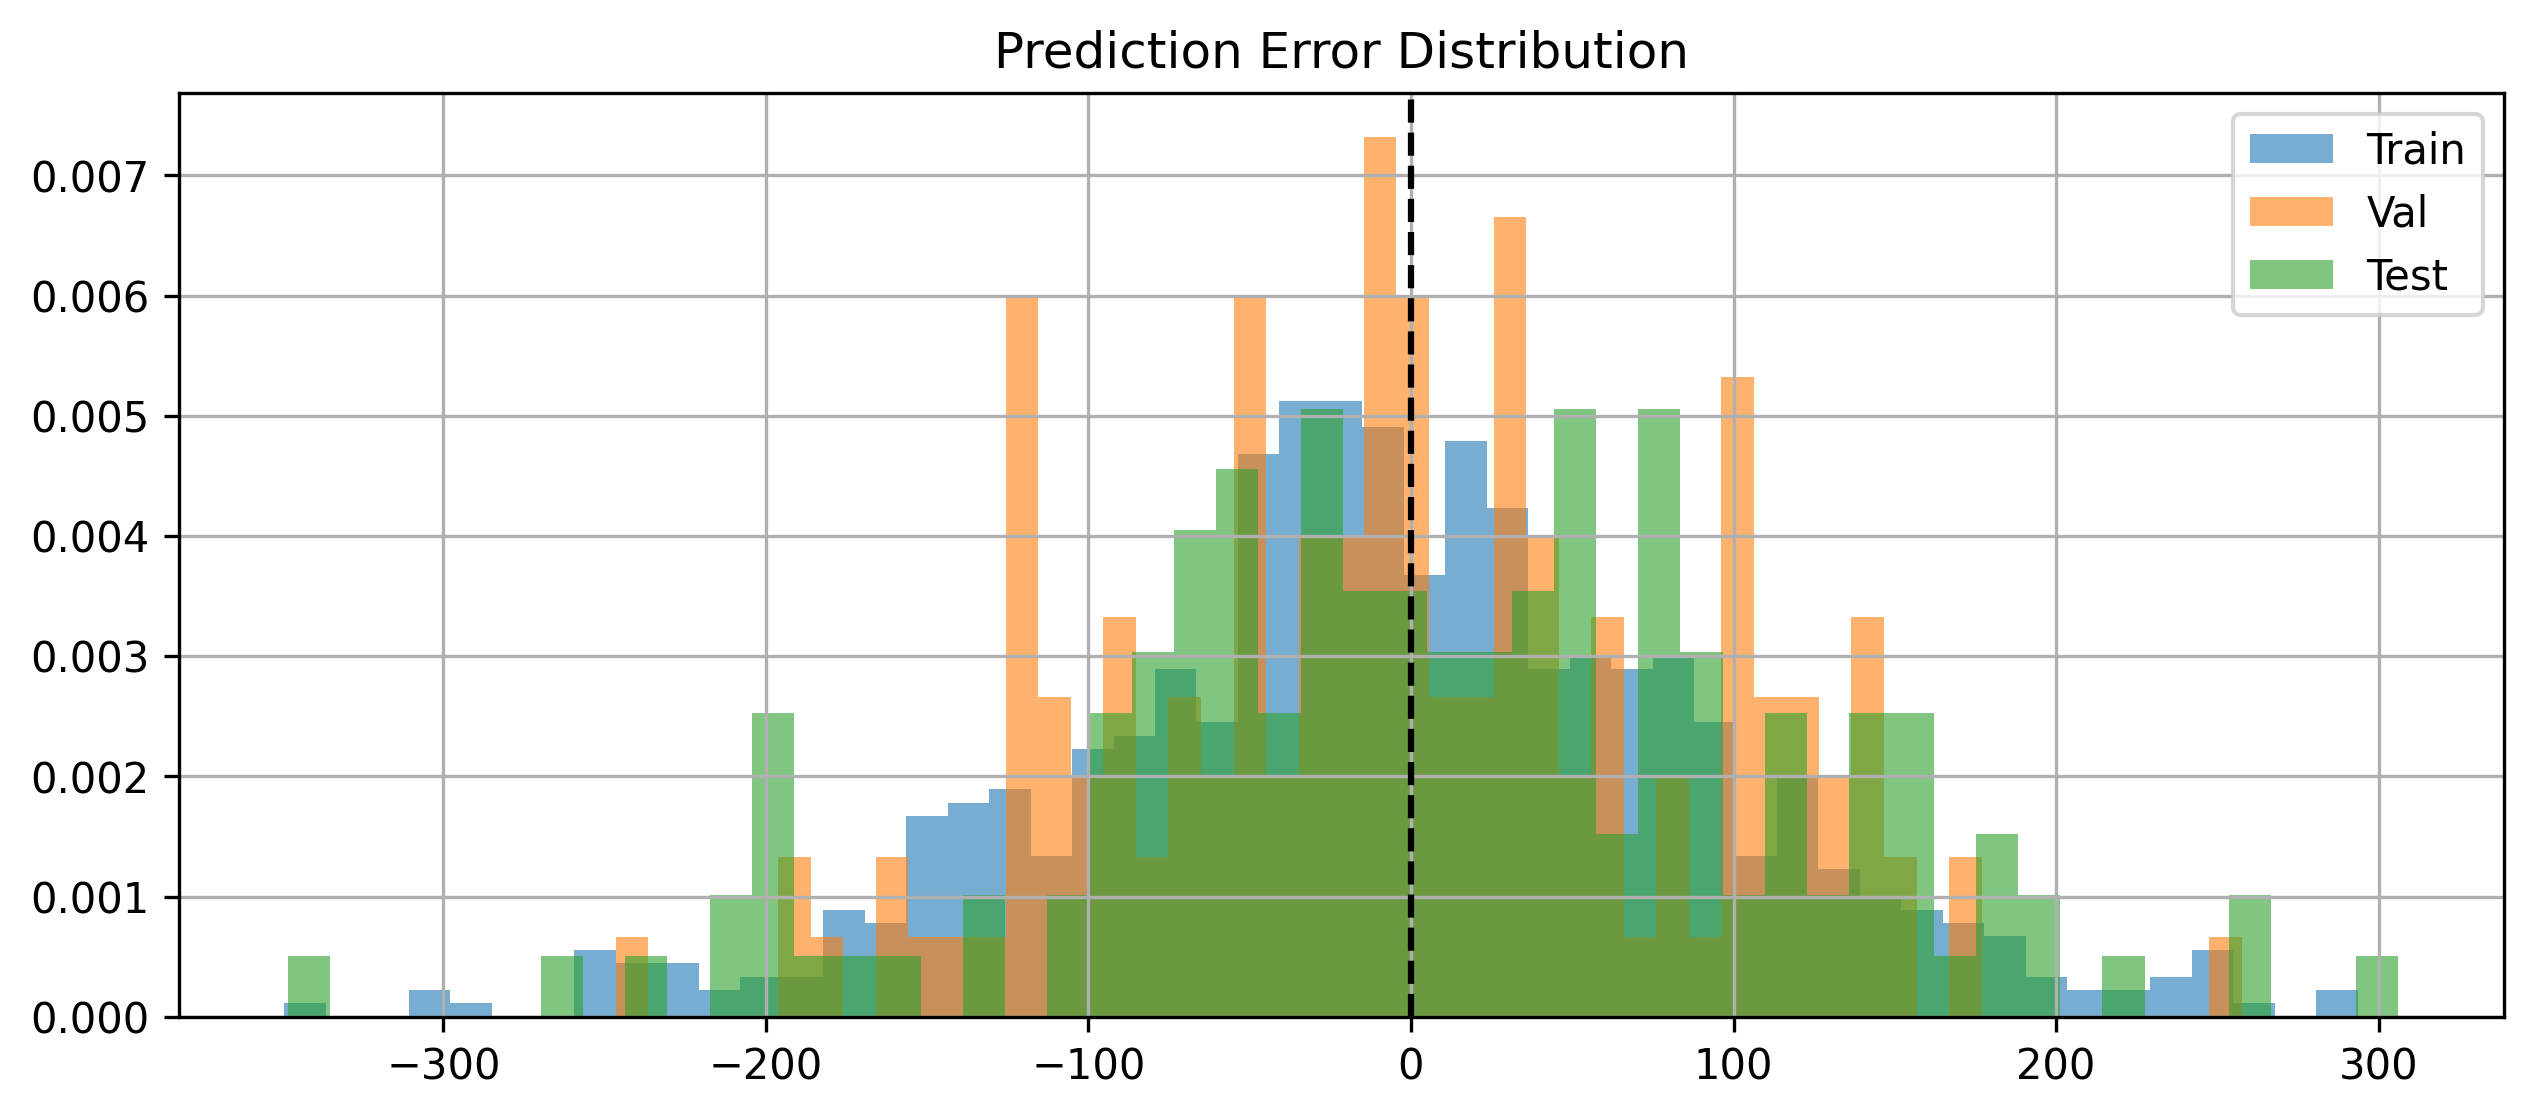


Coverage Probability (95% CI):
Train: 0.027
Val:   0.040
Test:  0.040

RMSE:
Train: 98.4294
Val:   89.9463
Test:  110.0042


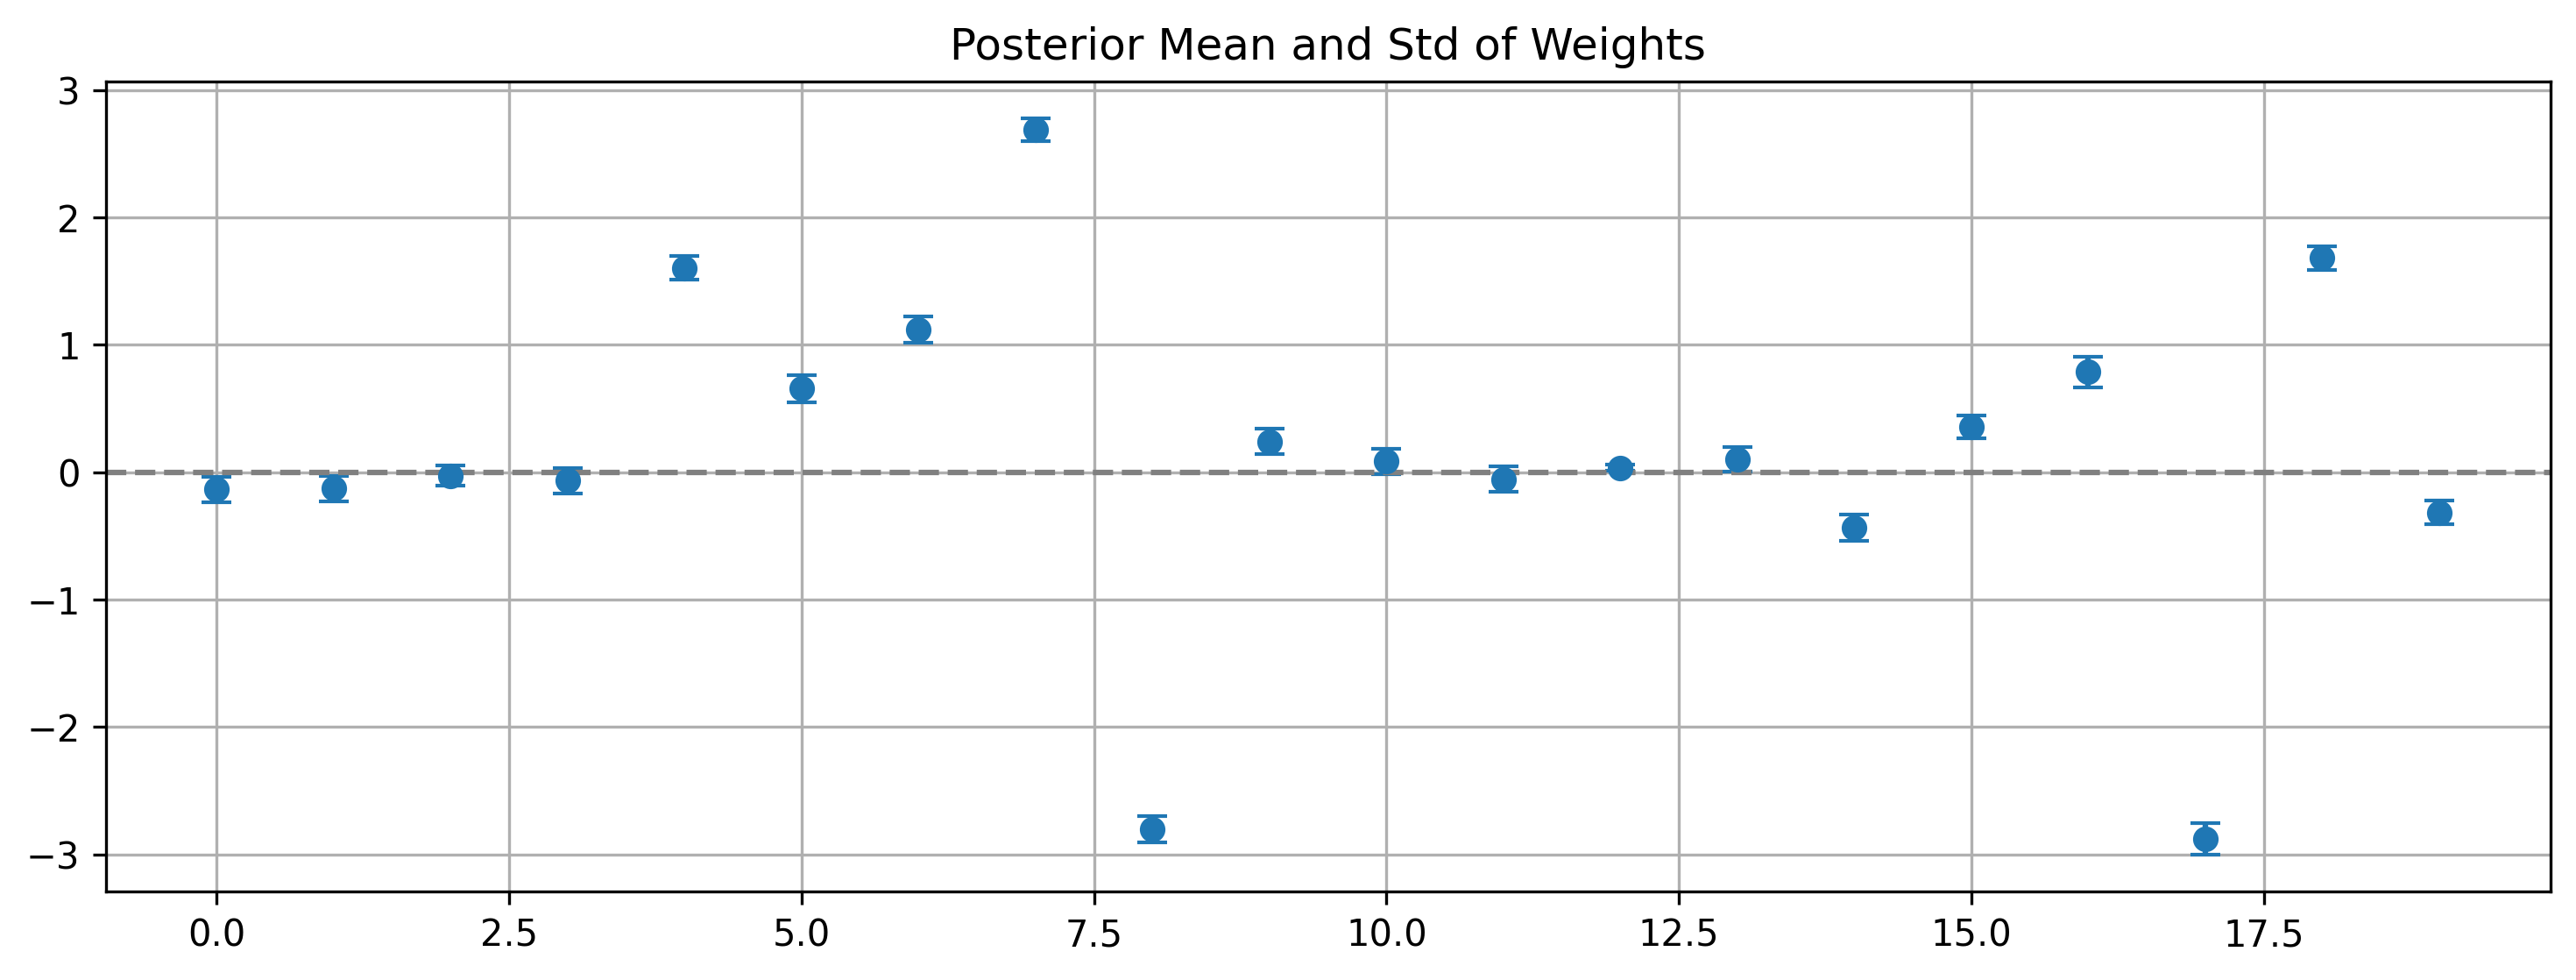

In [121]:
# ============================================================
#                 FULL BNAR EVALUATION CODE
# ============================================================

import numpy as np
import torch
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 1. Monte-Carlo Prediction with Uncertainty + Inverse Scaling
# ------------------------------------------------------------
def predict_with_uncertainty(model, X, n_samples=1000, scale_factor=1.0):
    """
    Generate predictive samples & compute mean, std, CI.
    Automatically inverts scaling using scale_factor.
    """
    model.eval()
    with torch.no_grad():
        samples = []
        for _ in range(n_samples):
            yhat, sigma_eps, _ = model.forward(X, sample=True, kl_weight=0.0)
            noisy = yhat + torch.randn_like(yhat) * sigma_eps
            samples.append(noisy.cpu().numpy())

        # shape: (N, samples)
        samples = np.array(samples).squeeze(-1).T

        # inverse scaling
        samples = samples * scale_factor

        # predictive stats
        pred_mean  = np.mean(samples, axis=1)
        pred_std   = np.std(samples, axis=1)
        pred_lower = np.percentile(samples, 2.5, axis=1)
        pred_upper = np.percentile(samples, 97.5, axis=1)

        return pred_mean, pred_std, pred_lower, pred_upper, samples


# ------------------------------------------------------------
# 2. Generate Predictions for Train/Val/Test
# ------------------------------------------------------------
print("Generating MC predictions...")

ytr_pred_mean, ytr_pred_std, ytr_pred_lower, ytr_pred_upper, tr_samples = \
    predict_with_uncertainty(model, Xtr_t, n_samples=1000, scale_factor=c)

yva_pred_mean, yva_pred_std, yva_pred_lower, yva_pred_upper, va_samples = \
    predict_with_uncertainty(model, Xva_t, n_samples=1000, scale_factor=c)

yte_pred_mean, yte_pred_std, yte_pred_lower, yte_pred_upper, te_samples = \
    predict_with_uncertainty(model, Xte_t, n_samples=1000, scale_factor=c)


# ------------------------------------------------------------
# 3. Inverse-Scaled True Values
# ------------------------------------------------------------
ytr_true = ytr_t.cpu().numpy().flatten() * c
yva_true = yva_t.cpu().numpy().flatten() * c
yte_true = yte_t.cpu().numpy().flatten() * c


# ------------------------------------------------------------
# 4. Time Indices
# ------------------------------------------------------------
time_tr = np.arange(len(ytr_true))
time_va = np.arange(len(ytr_true), len(ytr_true) + len(yva_true))
time_te = np.arange(len(ytr_true) + len(yva_true),
                    len(ytr_true) + len(yva_true) + len(yte_true))


# ============================================================
#                   FULL VISUALIZATION
# ============================================================

fig = plt.figure(figsize=(12, 20))

# ---------------------------
# Plot 1 — Full Series
# ---------------------------
ax1 = plt.subplot(5,1,1)

# Train
ax1.plot(time_tr, ytr_true, 'b-', label='True (Train)', alpha=0.7)
ax1.plot(time_tr, ytr_pred_mean, 'r-', label='Pred Mean (Train)')
ax1.fill_between(time_tr, ytr_pred_lower, ytr_pred_upper,
                 color='red', alpha=0.3, label='Train 95% CI')

# Val
ax1.plot(time_va, yva_true, 'b-', alpha=0.7, label='True (Val)')
ax1.plot(time_va, yva_pred_mean, 'g-', label='Pred Mean (Val)')
ax1.fill_between(time_va, yva_pred_lower, yva_pred_upper,
                 color='green', alpha=0.3, label='Val 95% CI')

# Test
ax1.plot(time_te, yte_true, 'b-', alpha=0.7, label='True (Test)')
ax1.plot(time_te, yte_pred_mean, 'purple', label='Pred Mean (Test)')
ax1.fill_between(time_te, yte_pred_lower, yte_pred_upper,
                 color='purple', alpha=0.3, label='Test 95% CI')

ax1.axvline(len(ytr_true), color='gray', linestyle='--')
ax1.axvline(len(ytr_true) + len(yva_true), color='gray', linestyle='--')

ax1.set_title("BNAR Predictions with 95% Uncertainty Bands")
ax1.legend()
ax1.grid(True)


# Plot 2: Training region zoom
ax2 = plt.subplot(5, 1, 2)
ax2.plot(time_tr[100:200], ytr_true[100:200], 'b-', alpha=0.8, label='True', linewidth=2)
ax2.plot(time_tr[100:200], ytr_pred_mean[100:200], 'r-', label='Pred Mean', linewidth=2)
ax2.fill_between(time_tr[100:200], ytr_pred_lower[100:200], ytr_pred_upper[100:200],
                      alpha=0.3, color='red', label='95% CI')
ax2.set_title(f'Training Region Model {id} (Zoom: Time Steps 100-200)')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Validation region zoom
ax3 = plt.subplot(5, 1, 3)
ax3.plot(time_va[:100], yva_true[:100], 'b-', alpha=0.8, label='True', linewidth=2)
ax3.plot(time_va[:100], yva_pred_mean[:100], 'g-', label='Pred Mean', linewidth=2)
ax3.fill_between(time_va[:100], yva_pred_lower[:100], yva_pred_upper[:100],
                      alpha=0.3, color='green', label='95% CI')
ax3.set_title(f'Validation Region Model {id} (Zoom: First 100 Points)')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Test region zoom
ax4 = plt.subplot(5, 1, 4)
ax4.plot(time_te[:100], yte_true[:100], 'b-', alpha=0.8, label='True', linewidth=2)
ax4.plot(time_te[:100], yte_pred_mean[:100], 'purple', label='Pred Mean', linewidth=2)
ax4.fill_between(time_te[:100], yte_pred_lower[:100], yte_pred_upper[:100],
                      alpha=0.3, color='purple', label='95% CI')
ax4.set_title(f'Test Region Model {id} (Zoom: First 100 Points)')
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Value')
ax4.legend()
ax4.grid(True, alpha=0.3)


# ---------------------------
# Plot 5 — Scatter (True vs Pred)
# ---------------------------
ax5 = plt.subplot(5,1,5)

ax5.scatter(ytr_true, ytr_pred_mean, alpha=0.6, label='Train')
ax5.scatter(yva_true, yva_pred_mean, alpha=0.6, label='Val')
ax5.scatter(yte_true, yte_pred_mean, alpha=0.6, label='Test')

mn = min(ytr_true.min(), ytr_pred_mean.min())
mx = max(ytr_true.max(), ytr_pred_mean.max())
ax5.plot([mn, mx], [mn, mx], 'k--')

ax5.set_title("Prediction vs True (Scatter Plot)")
ax5.set_aspect("equal")
ax5.grid(True)
ax5.legend()

plt.tight_layout()
plt.show()


# ============================================================
#                   UNCERTAINTY + ERRORS
# ============================================================

# ---------------------------
# 6 — Uncertainty Over Time
# ---------------------------
plt.figure(figsize=(12,4))
plt.plot(time_tr, ytr_pred_std, 'r-', alpha=0.7, label='Train')
plt.plot(time_va, yva_pred_std, 'g-', alpha=0.7, label='Val')
plt.plot(time_te, yte_pred_std, 'purple', alpha=0.7, label='Test')
plt.axvline(len(ytr_true), color='gray', linestyle='--')
plt.axvline(len(ytr_true)+len(yva_true), color='gray', linestyle='--')
plt.title("Prediction Standard Deviation Over Time")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------
# 7 — Error Histogram
# ---------------------------
plt.figure(figsize=(10,4))

err_tr = ytr_pred_mean - ytr_true
err_va = yva_pred_mean - yva_true
err_te = yte_pred_mean - yte_true

plt.hist(err_tr, bins=50, density=True, alpha=0.6, label='Train')
plt.hist(err_va, bins=50, density=True, alpha=0.6, label='Val')
plt.hist(err_te, bins=50, density=True, alpha=0.6, label='Test')
plt.axvline(0, color='k', linestyle='--')
plt.title("Prediction Error Distribution")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------
# 8 — Coverage Probability (95%)
# ---------------------------
coverage_tr = np.mean((ytr_true >= ytr_pred_lower) & (ytr_true <= ytr_pred_upper))
coverage_va = np.mean((yva_true >= yva_pred_lower) & (yva_true <= yva_pred_upper))
coverage_te = np.mean((yte_true >= yte_pred_lower) & (yte_true <= yte_pred_upper))

print("\nCoverage Probability (95% CI):")
print(f"Train: {coverage_tr:.3f}")
print(f"Val:   {coverage_va:.3f}")
print(f"Test:  {coverage_te:.3f}")


# ---------------------------
# 9 — RMSE
# ---------------------------
rmse_tr = np.sqrt(np.mean(err_tr**2))
rmse_va = np.sqrt(np.mean(err_va**2))
rmse_te = np.sqrt(np.mean(err_te**2))

print("\nRMSE:")
print(f"Train: {rmse_tr:.4f}")
print(f"Val:   {rmse_va:.4f}")
print(f"Test:  {rmse_te:.4f}")


# ---------------------------
# 10 — Posterior Weights Mean and Std
# ---------------------------
weights = model.m_w.detach().cpu().numpy()
stds = torch.exp(model.log_diag_Lq).detach().cpu().numpy()

plt.figure(figsize=(12,4))
plt.errorbar(np.arange(len(weights)), weights, yerr=stds,
             fmt='o', capsize=4)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Posterior Mean and Std of Weights")
plt.grid(True)
plt.show()